# Case study 1: Constant mortality risk in *Frontinella pyramitela*

In [28]:
%load_ext autoreload 
%autoreload 2

import os
import sys  

import numpy as np

sys.path.insert(0, '../') # The following modules are in the directory above
import figures
from cohort_model import (
    get_mean_and_std,
    population_survivorship_difference, 
    run_cohort_simulation,
    HYP_WILDTYPE, 
    MUT_CAPTIVITY,
    MUT_WILD
)
from fitness import get_fitness_data

## Survivorship curves (Figure 1 in paper)

In [29]:
# Figure 1 parameters
individual_count = 1000 # Also used in figure 2
repetition_count = 100

t_m_captivity = 201
t_m_wild = 100
t_m_hyp_wt = 100

epsilon = 0.04

# The 4 parameters below are based on previous least-squares curve fitting 
# (see Frontinella parameter estimation notebook for method)
alpha = 0.000222             # Also used in figure 2
kappa = 0.033                # Also used in figure 2
hazard_rate_hypwt = 0.04015625

# Instantiate dictionary with parameters common to all three populations
hazard_rate_params = dict(hazard_rate_hypwt=hazard_rate_hypwt, epsilon=epsilon, alpha=alpha, kappa=kappa)

In [30]:
# Mutant captivity population
hazard_rate_params['population'] = MUT_CAPTIVITY
captivity_population = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_captivity)

# Mutant wild population
hazard_rate_params['population'] = MUT_WILD
wild_population = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_wild)

# Hypothetical wild type population
hazard_rate_params['population'] = HYP_WILDTYPE
hyp_wt_population = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_hyp_wt)

CPU times: user 8.01 s, sys: 7.56 s, total: 15.6 s
Wall time: 15.8 s


In [31]:
captivity_mean, captivity_std = get_mean_and_std(captivity_population)
wild_mean, _ = get_mean_and_std(wild_population)
hyp_wt_mean, hyp_wt_std = get_mean_and_std(hyp_wt_population)

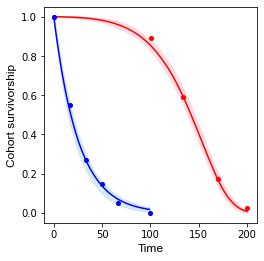

In [33]:
figures.plot_fig_1(
    t_m_captivity=t_m_captivity,
    t_m_wild=t_m_wild,
    t_m_hyp_wt=t_m_hyp_wt,
    captivity_mean=captivity_mean, 
    captivity_std=captivity_std, 
    wild_mean=wild_mean,
    hyp_wt_mean=hyp_wt_mean,
    hyp_wt_std=hyp_wt_std
)

## Predicted temporal difference between hypothetical wild type and mutant survivorship (Figure 2 in paper)

In [34]:
# Figure 2 parameters
repetition_count = 1000 # Also used in figure 3
t_m = 100               # Also used in figure 3
epsilons = np.array([0.01, 0.02, 0.03, 0.04])
hazard_rates_wt = np.array([0.03893939, 0.03933673, 0.039742268, 0.04015625]) # based on previous least-squares fitting: (1-epsilon)p_wt = 0.0385499

In [35]:
%%time
hazard_rate_params = dict(alpha=alpha, kappa=kappa)
population_simulations, mean_diff, std_diff = population_survivorship_difference(
    individual_count=individual_count,
    repetition_count=repetition_count,
    epsilons=epsilons,
    hazard_rates_wt=hazard_rates_wt,
    t_m=t_m,
    populations=(MUT_WILD, HYP_WILDTYPE),
    hazard_rate_params=hazard_rate_params
)

CPU times: user 1min 56s, sys: 1min 31s, total: 3min 28s
Wall time: 3min 31s


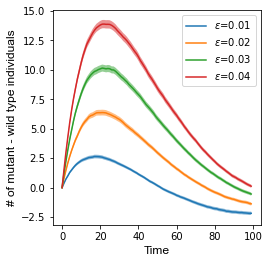

In [36]:
figures.plot_fig_2(t_m, mean_diff, std_diff, repetition_count)

## Difference between area under survivorship curves for mutant and hypothetical wild type (results reported in paper)

In [38]:
# Area under curve parameters, common to both female and male calculations
repetition_count = 1000
# epsilons = np.array([0., 0.01, 0.02, 0.03, 0.04]) # TODO: Already defined above
# hazard_rates_wt = np.array([0.0385499, 0.03893939, 0.03933673, 0.039742268, 0.04015625]) # TODO: Allerede definert
hazard_rate_params = dict(alpha=alpha, kappa=kappa)

In [39]:
%%time
population_simulations, _, _ = population_survivorship_difference(
    individual_count=individual_count,
    repetition_count=repetition_count,
    epsilons=epsilons,
    hazard_rates_wt=hazard_rates_wt,
    t_m=t_m_wild,
    populations=(MUT_WILD, HYP_WILDTYPE),
    hazard_rate_params=hazard_rate_params
)

survivorship_mut = np.array(population_simulations[MUT_WILD])
survivorship_hyp_wt = np.array(population_simulations[HYP_WILDTYPE])

CPU times: user 2min 2s, sys: 1min 36s, total: 3min 38s
Wall time: 3min 46s


In [40]:
# Calculate the percentage of cases where the mutant has a larger area under the curve than the hypothetical wild type
area_mut = np.trapz(survivorship_mut)
area_hyp_wt = np.trapz(survivorship_hyp_wt)
area_diff = np.subtract(area_mut, area_hyp_wt)
percentage_diff = np.sum(area_diff > 0, axis=1) / repetition_count * 100

In [41]:
print(f"Wild mutant wins {[float(x) for x in percentage_diff]} percent of the time at epsilon values of {[float(num) for num in epsilons]}, respectively.\n")

Wild mutant wins [56.39999999999999, 99.2, 100.0, 100.0] percent of the time at epsilon values of [0.01, 0.02, 0.03, 0.04], respectively.



## Pairwise comparison of predicted lifetime reproductive success and intrinsic rate of increase for the hypothetical wild type and mutant females (Figure 3 in paper)

In [42]:
# Figure 3 parameters
# The population_simulations parameter is carried over as a result from calculations for figure 2
fertility_wt = [(39, 24.0), (79, 24.0)]
fertility_mut = [(39, 24.0), (79, 18.0)]

In [43]:
fitness_stats_wt = get_fitness_data(population_simulations[HYP_WILDTYPE], fertility_wt)
fitness_stats_mut = get_fitness_data(population_simulations[MUT_WILD], fertility_mut)

CPU times: user 1.52 s, sys: 41.2 ms, total: 1.56 s
Wall time: 1.55 s


Increase in R0 from hypothetical wild type to mutant: 1.36%
Increase in r from hypothetical wild type to mutant: 2.76%


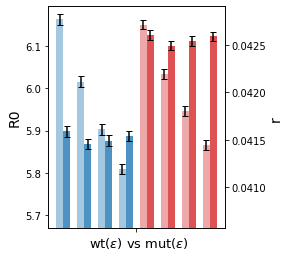

In [44]:
figures.plot_fig_3(fitness_stats_wt, fitness_stats_mut)

r0_wt_mean = fitness_stats_wt['r0_mean']
r_wt_mean = fitness_stats_wt['r_mean']
r0_mut_mean = fitness_stats_mut['r0_mean']
r_mut_mean = fitness_stats_mut['r_mean']

print(f"Increase in R0 from hypothetical wild type to mutant: {(r0_mut_mean[3] - r0_wt_mean[3]) / r0_wt_mean[3] * 100:.2f}%")
print(f"Increase in r from hypothetical wild type to mutant: {(r_mut_mean[3] - r_wt_mean[3]) / r_wt_mean[3] * 100:.2f}%")